# Tsetlin maskin eksempel

I dette eksempelet implementerer vi en Tsetlin-klausul som kan lære én regel fra et datasett med 6 brystkreftpasienter.

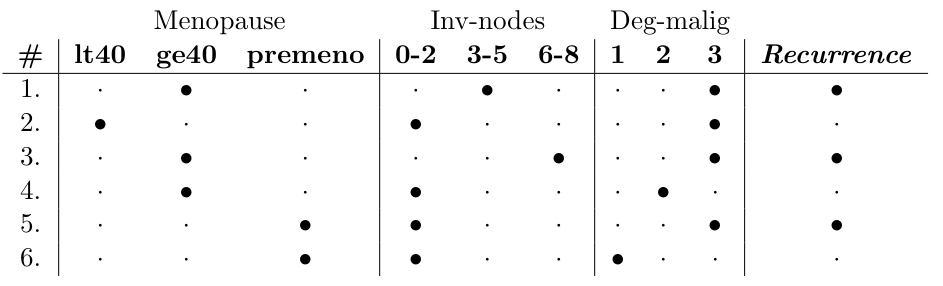

## Representasjon av pasientdata

Dette vil hjelpe oss når vi oppretter datasettet.
`full_observation` returnerer observasjonsvektoren med både egenskaper (features) og deres negasjoner. Dette er literal-representasjonen som brukes av Tsetlin-klausulen.
`full_features` returnerer navnene på egenskapene med negasjoner. Dette brukes til å skrive ut den lærte regelen.


In [16]:
from dataclasses import dataclass

import numpy as np
from numpy.typing import NDArray


@dataclass
class Patient:
    Menopause: str
    Inv_nodes: str
    Deg_malig: int
    Recurrence: bool

    def to_dict(self) -> dict[str, bool]:
        return {
            "Menopause_lt40": self.Menopause == "lt40",
            "Menopause_ge40": self.Menopause == "ge40",
            "Menopause_premeno": self.Menopause == "premeno",
            "Inv_nodes_0_2": self.Inv_nodes == "0-2",
            "Inv_nodes_3_5": self.Inv_nodes == "3-5",
            "Inv_nodes_6_8": self.Inv_nodes == "6-8",
            "Deg_malig_1": self.Deg_malig == "1",
            "Deg_malig_2": self.Deg_malig == "2",
            "Deg_malig_3": self.Deg_malig == "3",
        }


    def observation(self) -> NDArray[np.bool_]:
        return np.array([
            self.Menopause == "lt40",
            self.Menopause == "ge40",
            self.Menopause == "premeno",
            self.Inv_nodes == "0-2",
            self.Inv_nodes == "3-5",
            self.Inv_nodes == "6-8",
            self.Deg_malig == "1",
            self.Deg_malig == "2",
            self.Deg_malig == "3",
        ])


    def full_observation(self) -> NDArray[np.bool_]:
        return np.concatenate([self.observation(), ~self.observation()])


    def features(self) -> list[str]:
        return list(self.to_dict().keys())


    def full_features(self) -> list[str]:
        features = self.features()
        not_features = ["¬" + f for f in features]
        return features + not_features



### Testing av Patient klassen

In [17]:
def test_patient_1():
    patient = Patient("ge40", "3-5", 3, True)
    print(patient.to_dict())
    print(patient.observation())
    print(patient.full_observation())
    print(patient.full_features())

test_patient_1()

{'Menopause_lt40': False, 'Menopause_ge40': True, 'Menopause_premeno': False, 'Inv_nodes_0_2': False, 'Inv_nodes_3_5': True, 'Inv_nodes_6_8': False, 'Deg_malig_1': False, 'Deg_malig_2': False, 'Deg_malig_3': False}
[False  True False False  True False False False False]
[False  True False False  True False False False False  True False  True
  True False  True  True  True  True]
['Menopause_lt40', 'Menopause_ge40', 'Menopause_premeno', 'Inv_nodes_0_2', 'Inv_nodes_3_5', 'Inv_nodes_6_8', 'Deg_malig_1', 'Deg_malig_2', 'Deg_malig_3', '¬Menopause_lt40', '¬Menopause_ge40', '¬Menopause_premeno', '¬Inv_nodes_0_2', '¬Inv_nodes_3_5', '¬Inv_nodes_6_8', '¬Deg_malig_1', '¬Deg_malig_2', '¬Deg_malig_3']


### Brkrystkreft Pasient Datasett

Datasett av 6 brystkreftpasienter med ulike egenskaper og om de fikk tilbakefall (recurrence) eller ikke.

In [18]:
patients = [
    Patient("ge40", "3-5", 3, True),
    Patient("lt40", "0-2", 3, False),
    Patient("ge40", "6-8", 3, True),
    Patient("ge40", "0-2", 2, False),
    Patient("premeno", "0-2", 3, True),
    Patient("premeno", "0-2", 1, False)
]

## Håndlaging av Klassifiseringsregler

Vi kan lage manuelle klassifiseringsregler for å prøve å forutsi tilbakefall.

In [19]:
def R1(p: Patient) -> bool:
    return p.Deg_malig == 3 and p.Menopause != "lt40"

def R2(p: Patient) -> bool:
    return p.Deg_malig == 3

def R3(p: Patient) -> bool:
    return p.Inv_nodes == "0-2"

### Klassifisering av pasienter med manuelle regler

Vi tester våre manuelle regler på pasientdatasettet.

In [20]:
for i, p in enumerate(patients):
    print(f"Patient {i+1}: {p.Menopause}, {p.Inv_nodes}, {p.Deg_malig}, Recurrence: {p.Recurrence}")
    print(f"=> R1: {R1(p)}, R2: {R2(p)}, R3: {R3(p)}\n")

Patient 1: ge40, 3-5, 3, Recurrence: True
=> R1: True, R2: True, R3: False

Patient 2: lt40, 0-2, 3, Recurrence: False
=> R1: False, R2: True, R3: True

Patient 3: ge40, 6-8, 3, Recurrence: True
=> R1: True, R2: True, R3: False

Patient 4: ge40, 0-2, 2, Recurrence: False
=> R1: False, R2: False, R3: True

Patient 5: premeno, 0-2, 3, Recurrence: True
=> R1: True, R2: True, R3: True

Patient 6: premeno, 0-2, 1, Recurrence: False
=> R1: False, R2: False, R3: True



## Tsetlin Clause Implementation

The Tsetlin Clause can learn one rule from a dataset.
As we understand it, Tsetlin Machines typically consist of multiple clauses, but for this assignment we focus on a single clause to learn a specific rule.
Type 1 feedback is used for positive reward (correct classification), while Type 2 feedback is used for negative reward (incorrect classification).

In [21]:
from dataclasses import dataclass, field

import numpy as np
from numpy.typing import NDArray


@dataclass
class TsetlinClause:
    memory_size: int
    num_of_automata: int
    states: NDArray[np.int_] = field(init=False)

    def __post_init__(self) -> None:
        self.states = np.random.randint(1, 2*self.memory_size + 1, size=self.num_of_automata)


    def _clipped_step(self, step: NDArray[np.int_]) -> None:
        self.states = np.clip(self.states + step, 1, 2*self.memory_size)


    def _probability_vector(self, probability: float) -> NDArray[np.bool_]:
        return np.random.rand(self.num_of_automata) < probability


    def reset(self) -> None:
        self.states = np.ones(self.num_of_automata, dtype=int)


    def update(self, rewards: NDArray[np.bool_]) -> None:
        direction = np.where(self.states > self.memory_size, 1, -1)
        step = np.where(rewards, direction, -direction)
        self._clipped_step(step)


    def memorize(self, literals: NDArray[np.bool_], memorize_value: float) -> None:
        transition = literals & self._probability_vector(memorize_value)
        step = np.where(transition, 1, 0)
        self._clipped_step(step)


    def forget(self, literals: NDArray[np.bool_], forget_value: float) -> None:
        transition = literals & self._probability_vector(forget_value)
        step = np.where(transition, -1, 0)
        self._clipped_step(step)


    def get_actions(self) -> NDArray[np.bool_]:
        return self.states > self.memory_size


    def get_states(self) -> NDArray[np.int_]:
        return self.states.copy()


    def get_rule(self, features: list[str]) -> str:
        actions = self.get_actions()
        included = [f for action, f in zip(actions, features) if action]
        return " ∧ ".join(included) if included else "⊤"


    def condition(self, observation: NDArray[np.bool_]) -> tuple[np.bool_, NDArray[np.bool_]]:
        mem_literals = self.states > self.memory_size
        true_literals = observation & mem_literals
        return np.all(true_literals[mem_literals]), true_literals


    def vote(self, observation: NDArray[np.bool_]) -> int:
        fired, _ = self.condition(observation)
        return 1 if fired else 0


    def type_i_feedback(self, observation: NDArray[np.bool_], memorize_value: float) -> None:
        forget_value = 1 - memorize_value
        condition, true_literals = self.condition(observation)
        if condition:
            self.memorize(true_literals, memorize_value)
            self.forget(~true_literals, forget_value)
        else:
            all_literals = np.ones(self.num_of_automata, dtype=bool)
            self.forget(all_literals, forget_value)


    def type_ii_feedback(self, observation: NDArray[np.bool_]) -> None:
        condition, true_literals = self.condition(observation)
        if condition:
            memorize_literals = ~true_literals & (self.states <= self.memory_size)
            self.memorize(memorize_literals, 1.0)


## Learning Rules with Mixed Feedback

We separate between epochs and steps per epoch to allow for controlled shuffling of the data.

In [22]:
def learn_rule(
    memorize_value: float,
    learn_recurrence: bool,
    memory_size: int = 10,
    epochs: int = 100,
    steps_per_epoch: int = 10,
    seed: int = 0,
) -> None:
    rng = np.random.default_rng(seed)

    full_features = patients[0].full_features()
    observations  = [p.full_observation() for p in patients]

    idx_pos = [i for i, p in enumerate(patients) if p.Recurrence]
    idx_neg = [i for i, p in enumerate(patients) if not p.Recurrence]

    clause = TsetlinClause(memory_size=memory_size, num_of_automata=len(full_features))
    clause.states.fill(memory_size // 2)

    for _ in range(epochs):
        rng.shuffle(idx_pos)
        rng.shuffle(idx_neg)

        for k in range(steps_per_epoch):
            i_pos = idx_pos[k % len(idx_pos)]
            i_neg = idx_neg[k % len(idx_neg)]
            x_pos = observations[i_pos]
            x_neg = observations[i_neg]

            if learn_recurrence:
                clause.type_i_feedback(x_pos, memorize_value)
                clause.type_ii_feedback(x_neg)
            else:
                clause.type_i_feedback(x_neg, memorize_value)
                clause.type_ii_feedback(x_pos)

    rule_type = "Recurrence" if learn_recurrence else "Non-recurrence"
    rule_str  = f"IF {clause.get_rule(full_features)} THEN {rule_type}"
    print(rule_str)

### Scenario 1: memorize_value = 0.2, forget_value = 0.8

In [27]:
learn_rule(0.2, True)
learn_rule(0.2, False)

IF Inv_nodes_3_5 THEN Recurrence
IF Menopause_lt40 THEN Non-recurrence


### Scenario 2: memorize_value = 0.5, forget_value = 0.5

In [24]:
learn_rule(0.5, True)
learn_rule(0.5, False)

IF ¬Inv_nodes_0_2 THEN Recurrence
IF ¬Menopause_ge40 THEN Non-recurrence


### Scenario 3: memorize_value = 0.8, forget_value = 0.2

In [25]:
learn_rule(0.8, True)
learn_rule(0.8, False)

IF ¬Inv_nodes_0_2 ∧ ¬Inv_nodes_3_5 THEN Recurrence
IF Menopause_lt40 THEN Non-recurrence
